In [5]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Load your data
SFH_data = np.load('Latent data/SFHdata.npy')
labels_data = np.load('Latent data/labels_vectors.npy')
mass_sfr = np.load('Latent data/masspresentsfr.npy')

# Step 1: Split the data into train, validation, and test sets
SFH_train_val, SFH_test, labels_train_val, labels_test, mass_sfr_train_val, mass_sfr_test = train_test_split(
    SFH_data, labels_data, mass_sfr, test_size=0.2, random_state=42)

SFH_train, SFH_val, labels_train, labels_val, mass_sfr_train, mass_sfr_val = train_test_split(
    SFH_train_val, labels_train_val, mass_sfr_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 validation

# Step 2: Convert the data splits to tensors
SFH_train_tensor = torch.tensor(SFH_train, dtype=torch.float32)
SFH_val_tensor = torch.tensor(SFH_val, dtype=torch.float32)
SFH_test_tensor = torch.tensor(SFH_test, dtype=torch.float32)

labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.float32)

mass_sfr_train_tensor = torch.tensor(mass_sfr_train, dtype=torch.float32)
mass_sfr_val_tensor = torch.tensor(mass_sfr_val, dtype=torch.float32)
mass_sfr_test_tensor = torch.tensor(mass_sfr_test, dtype=torch.float32)

# Step 3: Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(SFH_train_tensor, labels_train_tensor, mass_sfr_train_tensor)
val_dataset = TensorDataset(SFH_val_tensor, labels_val_tensor, mass_sfr_val_tensor)
test_dataset = TensorDataset(SFH_test_tensor, labels_test_tensor, mass_sfr_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=200, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)


In [7]:
device = torch.device("mps")

In [8]:
# Building an MLP model
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=4, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=4, padding=1)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.fc1 = nn.Linear(16 * 7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)  # Latent space
        
        # Decoder (Pathway 1)
        self.fc4 = nn.Linear(16, 32)
        self.fc5 = nn.Linear(32, 64)
        self.fc6 = nn.Linear(64, 16 * 7)
        self.deconv1 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv2 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv3 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        self.deconv4 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=2)

        # Pathway 2: MLP for simulation type classification
        self.fc_sim1 = nn.Linear(16, 100)
        self.fc_sim2 = nn.Linear(100, 100)
        self.fc_sim3 = nn.Linear(100, 10)
        
        # Pathway 3: MLP for SM and SFR prediction
        self.fc_sfr1 = nn.Linear(16, 200)
        self.fc_sfr2 = nn.Linear(200, 200)
        self.fc_sfr3 = nn.Linear(200, 200) 
        self.fc_sfr4 = nn.Linear(200, 2)  # Predicting SM and SFR

    def encoder(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 16 * 7)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        encoded = self.fc3(x)
        return encoded

    def decoder(self, x):
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = x.view(-1, 16, 7)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.relu(self.deconv3(x))
        x = torch.relu(self.deconv4(x))
        return x

    def sim_type_classifier(self, x):
        x = torch.relu(self.fc_sim1(x))
        x = torch.relu(self.fc_sim2(x))
        sim_type_output = self.fc_sim3(x)
        return sim_type_output

    def sfr_predictor(self, x):
        x = torch.relu(self.fc_sfr1(x))
        x = torch.relu(self.fc_sfr2(x))
        x = torch.relu(self.fc_sfr3(x))
        sfr_output = self.fc_sfr4(x)
        return sfr_output
    
    def forward(self, x):
        latent = self.encoder(x)
        
        # Pathway 1: Reconstruct SFH
        sfh_output = self.decoder(latent)
        
        # Pathway 2: Classify sim type
        sim_type_output = self.sim_type_classifier(latent)
        
        # Pathway 3: Predict SM and SFR
        sfr_output = self.sfr_predictor(latent)
        
        return sfh_output, sim_type_output, sfr_output


def compute_loss(sfh_output, sfh_target, sim_type_output, sim_type_target, mass_sfr_output, mass_sfr_target, w_reg, w_cl):
    mse_loss = nn.MSELoss()
    cross_entropy_loss = nn.CrossEntropyLoss()

    loss_sfh = mse_loss(sfh_output, sfh_target)
    loss_sim_type = cross_entropy_loss(sim_type_output, sim_type_target)
    loss_mass_sfr = mse_loss(mass_sfr_output, mass_sfr_target)

    total_loss = loss_sfh + w_reg * loss_mass_sfr + w_cl * loss_sim_type
    # print(f'Loss: {total_loss:.3f} | SFH Loss: {loss_sfh:.3f} | Sim Type Loss: {loss_sim_type:.3f} | Mass-SFR Loss: {loss_mass_sfr:.3f}')
    return total_loss, loss_sfh, loss_sim_type, loss_mass_sfr

AE = ConvAutoencoder().to(device)
optimizer = optim.Adam(AE.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

In [242]:
num_epochs = 800
losses = [] # To store training losses
losses_sfh = []  # To store SFH losses
losses_sim_type = []  # To store sim type losses
losses_mass_sfr = []  # To store mass-sfr losses
val_losses = []  # To store validation losses


for epoch in range(num_epochs):
    total_loss = 0.0
    for data in train_loader:
        inputs, sim_labels, mass_sfr = data
        optimizer.zero_grad()
        inputs = inputs.to(device)
        sim_labels = sim_labels.to(device)
        mass_sfr = mass_sfr.to(device)
        sfh_output, sim_type_output, mass_sfr_output = AE(inputs.unsqueeze(1))
        sfh_output = sfh_output.squeeze(1)
        loss = compute_loss(sfh_output, inputs, sim_type_output, sim_labels, mass_sfr_output, mass_sfr, 1, 1)
        loss = loss[0]
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    total_loss /= len(train_loader)
    losses.append(total_loss)
    
    # Validation phase
    AE.eval()
    val_loss = 0.0
    sfh_loss = 0.0
    sim_type_loss = 0.0
    mass_sfr_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, sim_labels, mass_sfr = data
            inputs = inputs.to(device)
            sim_labels = sim_labels.to(device)
            mass_sfr = mass_sfr.to(device)
            sfh_output, sim_type_output, mass_sfr_output = AE(inputs.unsqueeze(1))
            loss, loss_sfh, loss_sim_type, loss_mass_sfr = compute_loss(sfh_output, inputs, sim_type_output, sim_labels, mass_sfr_output, mass_sfr, 1, 1)
            val_loss += loss.item()
            sfh_loss += loss_sfh.item()
            sim_type_loss += loss_sim_type.item()
            mass_sfr_loss += loss_mass_sfr.item()
            
    
    val_loss /= len(val_loader)
    sfh_loss /= len(val_loader)
    sim_type_loss /= len(val_loader)
    mass_sfr_loss /= len(val_loader)
    val_losses.append(val_loss)
    losses_sfh.append(sfh_loss)
    losses_sim_type.append(sim_type_loss)
    losses_mass_sfr.append(mass_sfr_loss)
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Training Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}, SFH Loss: {sfh_loss:.4f}, Sim Type Loss: {sim_type_loss:.4f}, Mass-SFR Loss: {mass_sfr_loss:.4f}')
    
    scheduler.step()

print('Training complete')

Epoch [0/800], Training Loss: 24.2650, Val Loss: 13.1572, SFH Loss: 11.3344, Sim Type Loss: 1.4576, Mass-SFR Loss: 0.3651
Epoch [10/800], Training Loss: 3.3885, Val Loss: 14.6144, SFH Loss: 13.7640, Sim Type Loss: 0.6033, Mass-SFR Loss: 0.2471
Epoch [20/800], Training Loss: 3.0091, Val Loss: 14.0449, SFH Loss: 13.2881, Sim Type Loss: 0.5039, Mass-SFR Loss: 0.2529
Epoch [30/800], Training Loss: 2.6752, Val Loss: 14.1335, SFH Loss: 13.5680, Sim Type Loss: 0.3945, Mass-SFR Loss: 0.1710
Epoch [40/800], Training Loss: 2.4571, Val Loss: 14.5657, SFH Loss: 14.2330, Sim Type Loss: 0.2038, Mass-SFR Loss: 0.1289
Epoch [50/800], Training Loss: 2.2785, Val Loss: 14.3217, SFH Loss: 14.0118, Sim Type Loss: 0.1848, Mass-SFR Loss: 0.1250
Epoch [60/800], Training Loss: 2.2464, Val Loss: 14.0448, SFH Loss: 13.7070, Sim Type Loss: 0.2048, Mass-SFR Loss: 0.1331
Epoch [70/800], Training Loss: 2.2227, Val Loss: 13.9031, SFH Loss: 13.5502, Sim Type Loss: 0.1851, Mass-SFR Loss: 0.1678
Epoch [80/800], Training

KeyboardInterrupt: 

In [11]:
import matplotlib.pyplot as plt
plt.plot(losses_sfh, label='SFH Loss')
plt.plot(losses_sim_type, label='Sim Type Loss')
plt.plot(losses_mass_sfr, label='Mass-SFR Loss')
# show labels
plt.legend()
plt.title('Validation Losses')

NameError: name 'losses_sfh' is not defined

In [244]:
torch.save(AE, 'AE Models/multimodal2.pth')

In [9]:
AE = torch.load('AE Models/multimodal2.pth')

In [10]:
with torch.no_grad():
    y_pred_tensor = AE(SFH_test_tensor.unsqueeze(1).to(device))

pred_sfh = y_pred_tensor[0]
pred_sim = y_pred_tensor[1]
pred_mass_sfr = y_pred_tensor[2]

(torch.Size([12622, 2]), torch.Size([12622, 1, 139]))

In [10]:
stellar_mass = mass_sfr_test_tensor.T[0].to(device)
star_formation_rate = mass_sfr_test_tensor.T[1].to(device)
labels = labels_test_tensor.to(device)

pred_mass = pred_mass_sfr.T[0].to(device)
pred_sfr = pred_mass_sfr.T[1].to(device)

Score for log stellar mass: 0.7952109575271606
Score for arcsinh SFR: 0.6872902512550354

RMSE for Stellar Mass: 0.2847140431404114 
RMSE for SFR: 0.36981046199798584

Baseline RMSE for Stellar Mass: 0.6291518807411194 (Predicting the mean) 
Baseline RMSE for SFR: 0.6613151431083679 (Predicting the mean)

1,5,10,50,90,95,99 Percentiles for mass residuals: [-0.83298862 -0.45108676 -0.31372185  0.03472519  0.29779816  0.41549997
  0.80535316]

1,5,10,50,90,95,99 Percentiles for SFR residuals: [-1.14039972 -0.44014286 -0.2058902   0.09866376  0.44544817  0.61603324
  1.02612268]


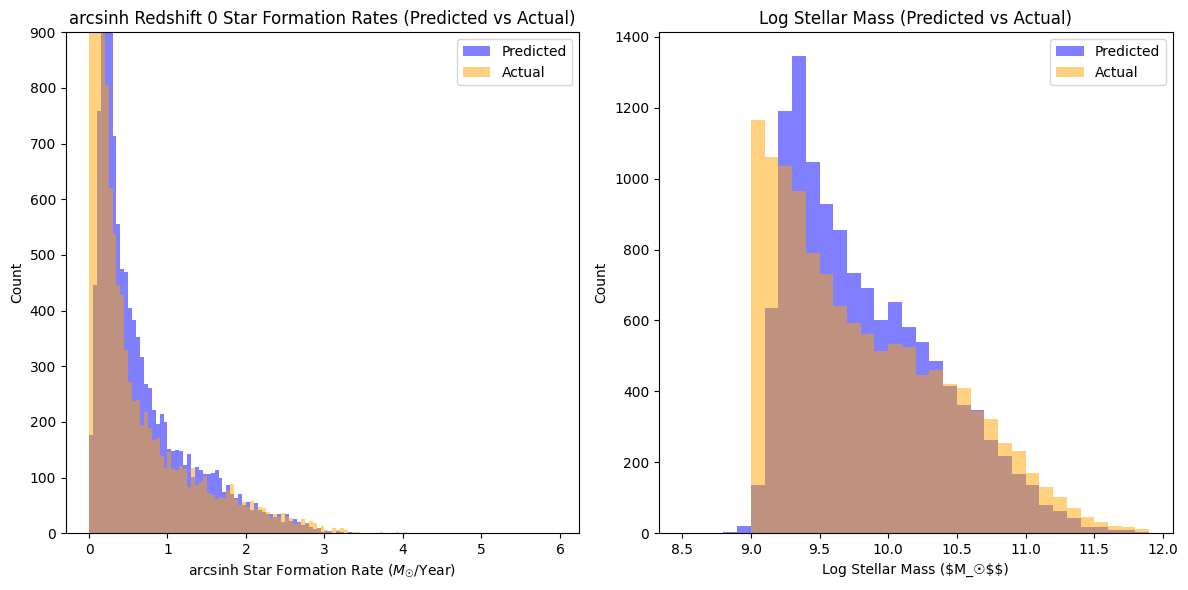

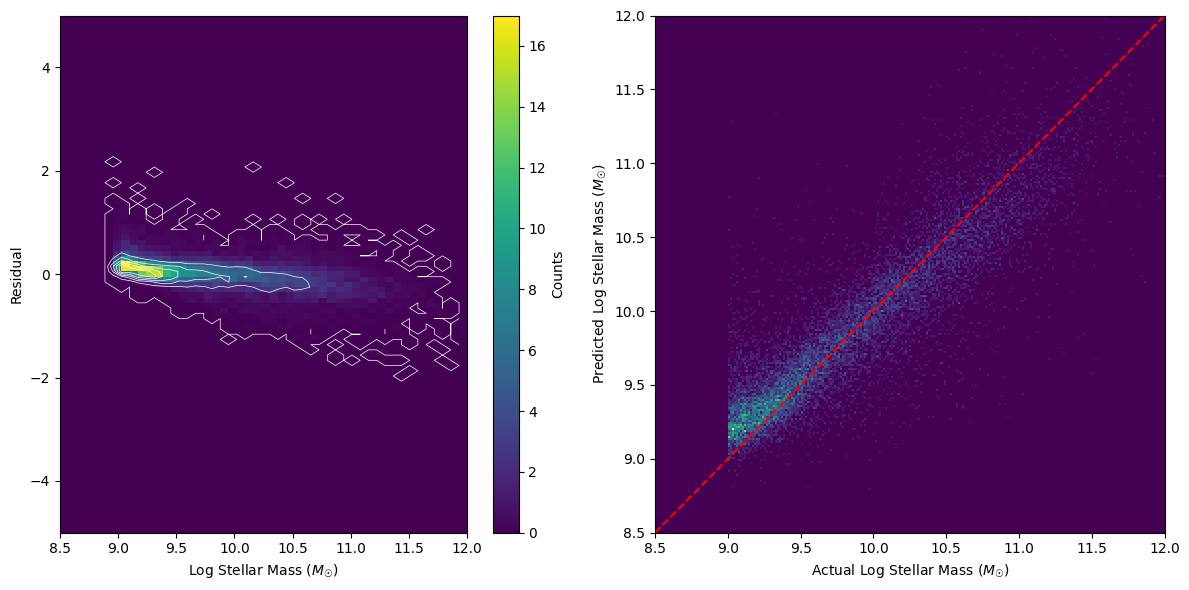

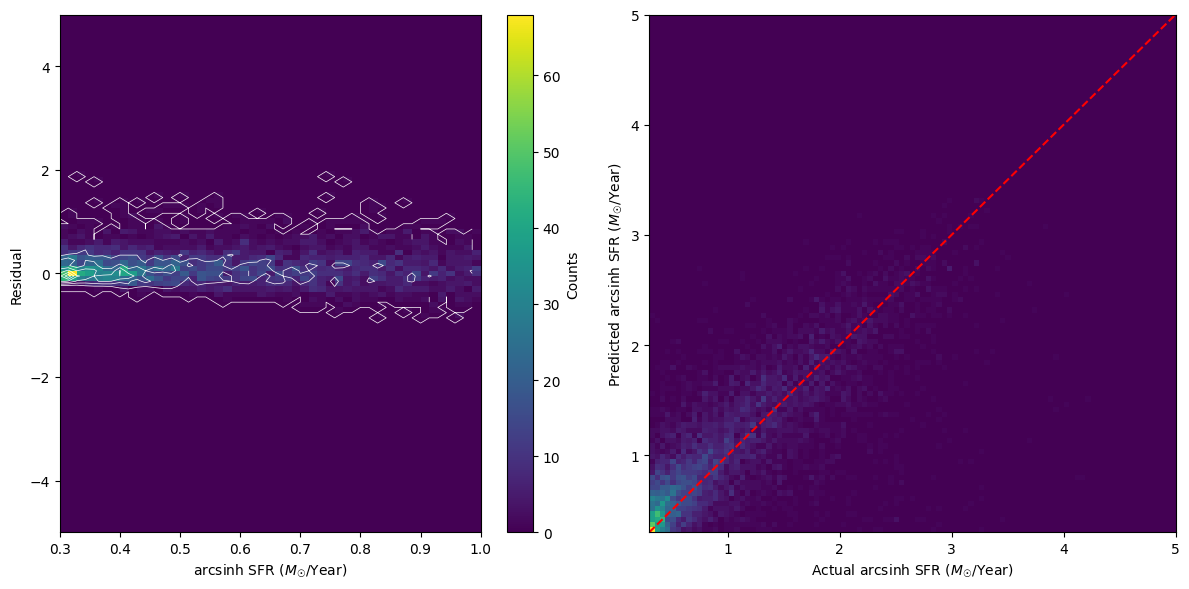

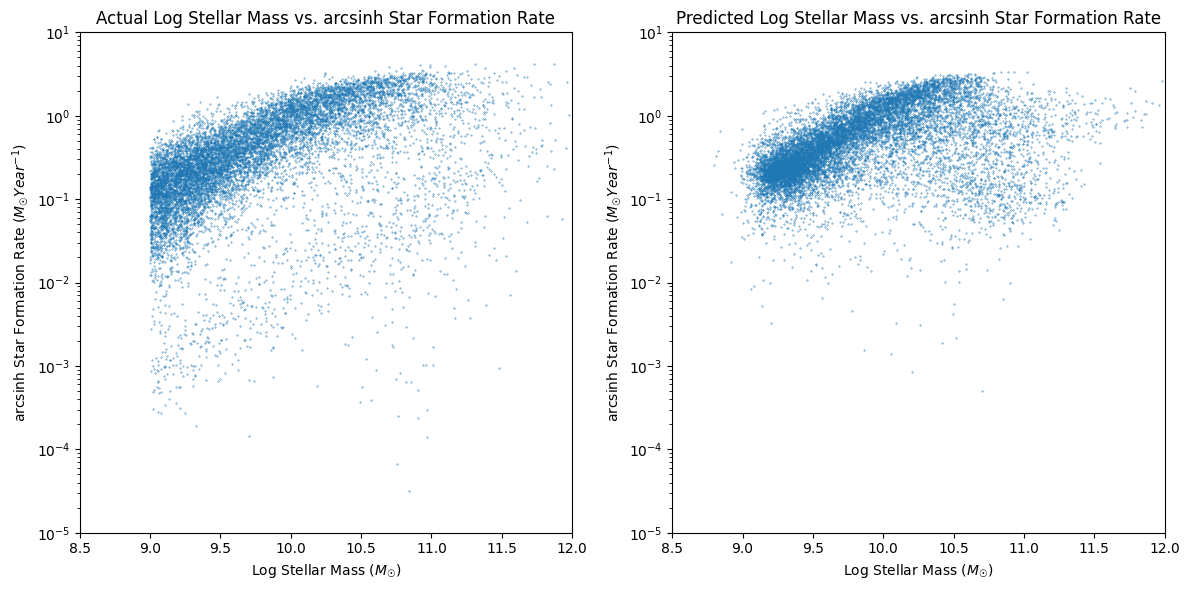

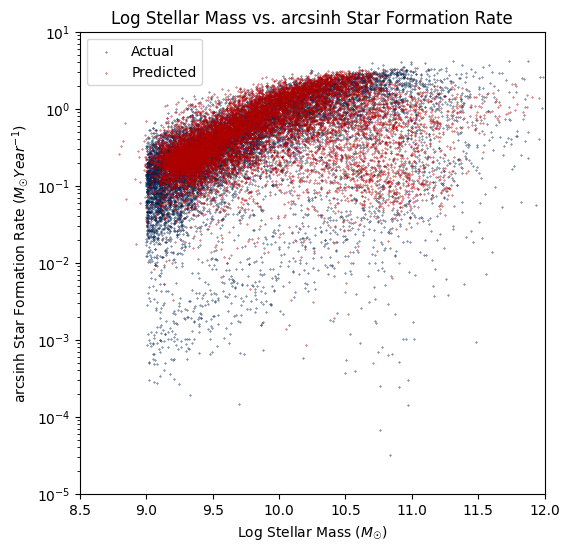

In [11]:
from DataEval import pred_actual_data_eval, pred_actual_data_vis
with torch.no_grad():
    y_pred_tensor = AE(SFH_test_tensor.unsqueeze(1).to(device))

pred_sfh = y_pred_tensor[0]
pred_sim = y_pred_tensor[1]
pred_mass_sfr = y_pred_tensor[2]
pred_mass_sfr.shape, pred_sfh.shape
stellar_mass = mass_sfr_test_tensor.T[0].to(device)
star_formation_rate = mass_sfr_test_tensor.T[1].to(device)
labels = labels_test_tensor.to(device)

pred_mass = pred_mass_sfr.T[0].to(device)
pred_sfr = pred_mass_sfr.T[1].to(device)
pred_actual_data_eval(pred_mass.cpu(), pred_sfr.cpu(), stellar_mass.cpu(), star_formation_rate.cpu())
pred_actual_data_vis(pred_mass.cpu(), pred_sfr.cpu(), stellar_mass.cpu(), star_formation_rate.cpu())

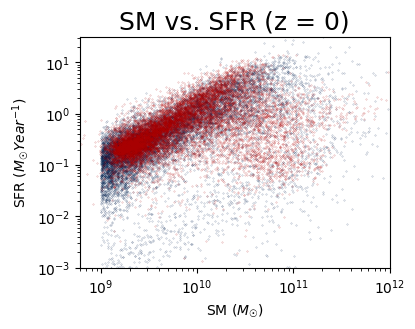

In [12]:
import matplotlib.pyplot as plt
# pred_mass.cpu(), pred_sfr.cpu(), stellar_mass.cpu(), star_formation_rate.cpu()
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
ax.scatter(10**stellar_mass.cpu(), (torch.sinh(star_formation_rate)).cpu(), s=0.05, alpha=0.5, label='Actual', color='#001F4E')
ax.scatter(10**pred_mass.cpu(), (torch.sinh(pred_sfr)).cpu(), s=0.05, alpha=0.5, label='Predicted', color='#AF0001')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(6e8, 1e12)
ax.set_ylim(1e-3, 3.16e1)
ax.set_xlabel('SM ($M_\u2609$)')
ax.set_ylabel('SFR ($M_\u2609 Year^{-1}$)')
ax.set_title('SM vs. SFR (z = 0)')
# making the dots on the legend bigger
plt.show()

In [14]:
test_outputs_categorical = np.zeros(pred_sim.shape)
for i in range(len(pred_sim)):
    _, indices = torch.max(pred_sim[i], 0)    
    predicted_label = indices.item()
    test_outputs_categorical[i][predicted_label] = 1

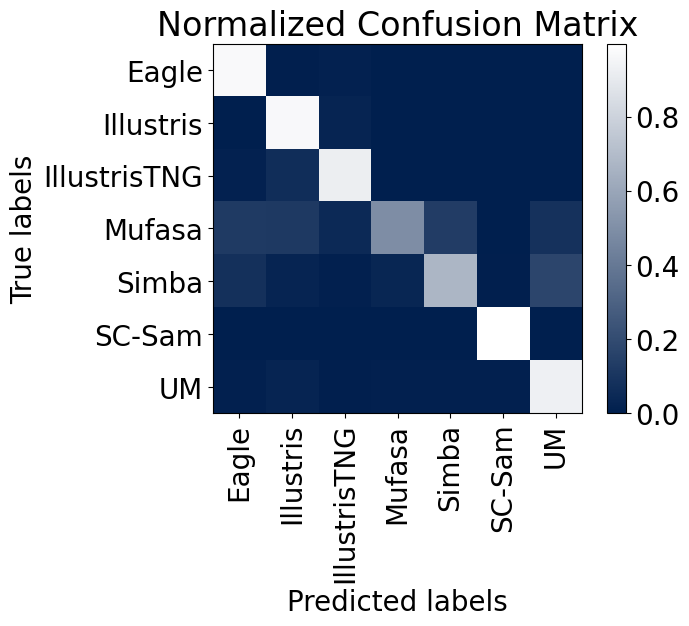

In [17]:
from matplotlib.colors import LinearSegmentedColormap
# Define a custom colormap
cmap = LinearSegmentedColormap.from_list(
    'custom_cmap', 
    [(0, '#001F4E'), (1, 'white')]
)

confusion_matrix = np.zeros((7, 7))
for i in range(len(test_outputs_categorical)):
    true_label = np.argmax(labels_test_tensor[i])
    predicted_label = np.argmax(test_outputs_categorical[i])
    if predicted_label == 7 or predicted_label == 8 or predicted_label == 9 or true_label == 7 or true_label == 8 or true_label == 9:
        continue
    confusion_matrix[true_label][predicted_label] += 1

# Calculate the sum of each row
row_sums = confusion_matrix.sum(axis=1)

# Normalize the confusion matrix
normalized_confusion_matrix = confusion_matrix / row_sums[:, np.newaxis]

plt.imshow(normalized_confusion_matrix, cmap=cmap, interpolation='nearest')

# Labelling the simulation names
sim_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UM']
plt.xticks(np.arange(7), sim_names, rotation=90)
plt.yticks(np.arange(7), sim_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.show()


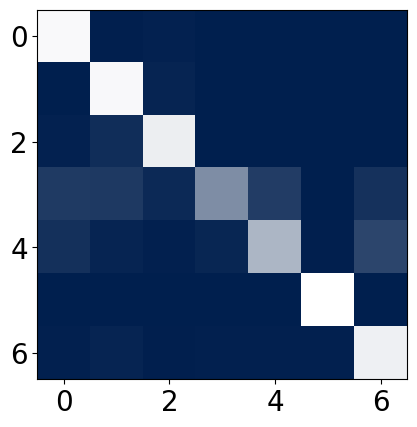

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Define a custom colormap
cmap = LinearSegmentedColormap.from_list(
    'custom_cmap', 
    [(0, '#001F4E'), (1, 'white')]
)

# Use the custom colormap in your plot
plt.imshow(normalized_confusion_matrix, cmap=cmap, interpolation='nearest')

In [19]:
# Printing the confusion matrix without scientific notation
np.set_printoptions(suppress=True)
print(confusion_matrix)

[[1423.   10.   19.    3.    2.    1.    4.]
 [  12. 3756.   91.   12.    2.    6.    8.]
 [  33.  152. 2236.    1.    2.    1.    5.]
 [  46.   45.   18.  187.   51.    1.   32.]
 [  32.   11.    4.   13.  273.    3.   71.]
 [   1.    2.    3.    0.    1. 2580.    1.]
 [  13.   35.   11.   14.   16.   16. 1352.]]


In [20]:
# calculate accuracy
correct = 0
for i in range(7):
    correct += confusion_matrix[i][i]
accuracy = correct / np.sum(confusion_matrix)
print(f'Accuracy: {accuracy * 100:.3f}%')

Accuracy: 93.625%


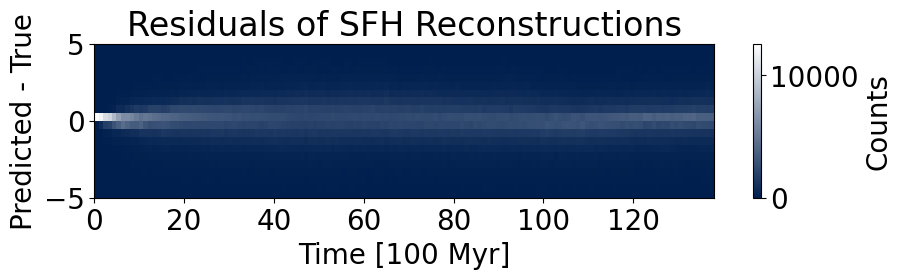

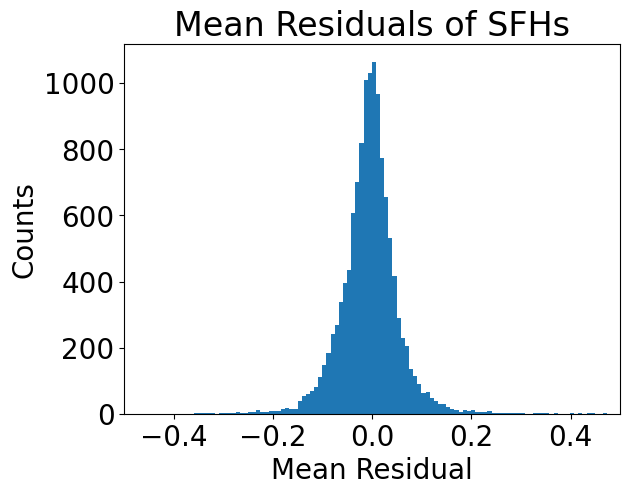

Mean sigma: 0.059


In [21]:
real_SFHs = SFH_test_tensor.unsqueeze(1).to(device)
# Calculate residuals
residuals = (pred_sfh - real_SFHs).detach().cpu().numpy().squeeze()

# Create time axis
time_axis = np.tile(np.arange(residuals.shape[1]), residuals.shape[0])

# Flatten the residuals
residuals_flat = residuals.flatten()

# Create a 2D histogram
plt.figure(figsize=(10, 2))
plt.hist2d(time_axis, residuals_flat, bins=[139, 200], cmap=cmap)
plt.ylim(-5,5)
plt.colorbar(label='Counts')
plt.xlabel('Time [100 Myr]')
plt.ylabel('Predicted - True')
plt.title('Residuals of SFH Reconstructions')
plt.show()

plt.hist([np.mean(residual) for residual in residuals], bins=150)
plt.xlabel('Mean Residual')
plt.ylabel('Counts')
plt.title('Mean Residuals of SFHs')
plt.xlim(-0.5, 0.5)
plt.show()

# Calculate sigma for the residuals
sigma = np.std([np.mean(residual) for residual in residuals])
# Calculate the mean of the stds
mean_sigma = np.mean(sigma)
print(f'Mean sigma: {mean_sigma:.3f}')

In [22]:
import numpy as np
import scipy.io as sio

work_dir = '/Users/pengzehao/Desktop/UofT/Astrostatistics/Iyer_etal_2020_SFH_data/'
extn = '_sfhs_psds.mat'

simulation_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'g14', 'Marvel_JL']
combined = []
for sim_name in simulation_names:
    sim_data = sio.loadmat(work_dir + sim_name + extn)
    print(sim_data.keys())
    # Interpolating SFHs into 139 timesteps 
    x = np.linspace(0, 14, 139) # creating general array to act as universal timestep array, with 139 timesteps
    sfhs = np.zeros((len(sim_data['smallsfhs'].T), 139)) # creating a np array of all 0s of size (number of galaxies, 139)
    xp = np.linspace(0, 14, len(sim_data['smallsfhs'].T[0])) 
    for i in range(len(sim_data['smallsfhs'].T)):
        sfhs[i] = np.interp(x, xp, sim_data['smallsfhs'].T[i])
        
    presentsfr = sfhs[:, -1]  # Accessing the last time step for redshift 0 sfr
    logmass = np.array(sim_data['logmass'].ravel())
    if sim_name in ['Simba', 'Mufasa']:
        combined = combined + [[arr, [m, np.arcsinh(s)], sim_name] for arr, m, s in zip(sfhs, logmass, presentsfr) if m > 10]
    else:
        combined = combined + [[arr, [m, np.arcsinh(s)], sim_name] for arr, m, s in zip(sfhs, logmass, presentsfr) if m > 9]
    # Setting a cut off for mass, categorized by simulation

dict_keys(['__header__', '__version__', '__globals__', 'smallsfhs', 'smalltime', 'logmass', 'logt_smooth', 'logpsd_sfhs'])
dict_keys(['__header__', '__version__', '__globals__', 'smallsfhs', 'smalltime', 'logmass', 'log_mhalo_illustris', 'logt_smooth', 'logpsd_sfhs'])
dict_keys(['__header__', '__version__', '__globals__', 'smallsfhs', 'smalltime', 'logmass', 'log_mhalo_tng', 'logt_smooth', 'logpsd_sfhs'])
dict_keys(['__header__', '__version__', '__globals__', 'smallsfhs', 'smalltime', 'logmass', 'logt_smooth', 'logpsd_sfhs'])
dict_keys(['__header__', '__version__', '__globals__', 'smallsfhs', 'smalltime', 'logmass', 'logt_smooth', 'logpsd_sfhs'])
dict_keys(['__header__', '__version__', '__globals__', 'smallsfhs', 'smalltime', 'logmass', 'logt_smooth', 'logpsd_sfhs'])
dict_keys(['__header__', '__version__', '__globals__', 'smallsfhs', 'smalltime', 'logmass', 'logt_smooth', 'logpsd_sfhs'])
dict_keys(['__header__', '__version__', '__globals__', 'smallsfhs', 'smalltime', 'logmass', 'logt_s

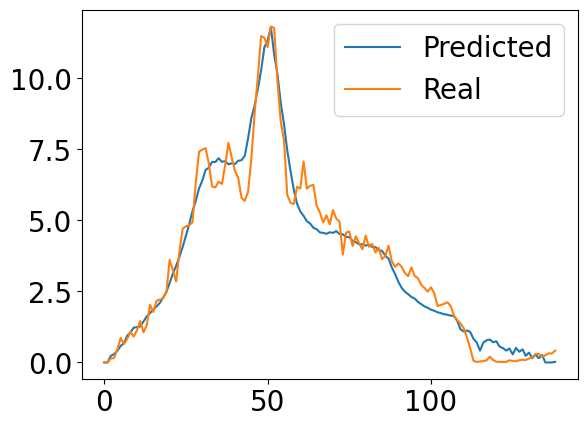

In [26]:
i = 42
AE = torch.load('AE Models/multimodal2.pth')
pred = AE(SFH_test_tensor.unsqueeze(1).to(device)[i])
plt.plot(pred[0].cpu().flatten().detach().numpy())
plt.plot(SFH_test_tensor[i])
# label
plt.legend(['Predicted', 'Real'])

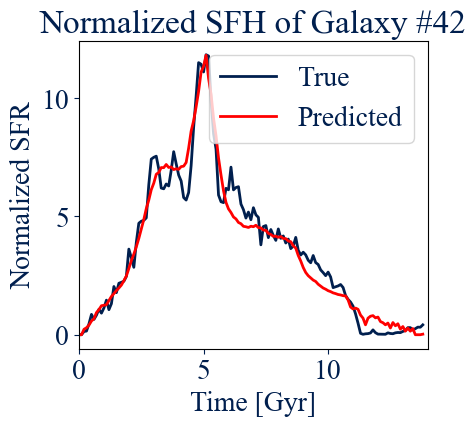

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Set the font to a serif font
# Set plot size
plt.rcParams["figure.figsize"] = (4.5, 4)
plt.rcParams["font.family"] = "Times New Roman"

# Set the color of everything to '#001F4E'
plt.rcParams['text.color'] = '#001F4E'
plt.rcParams['axes.labelcolor'] = '#001F4E'
plt.rcParams['xtick.color'] = '#001F4E'
plt.rcParams['ytick.color'] = '#001F4E'

# Plot the real data
plt.plot(SFH_test_tensor[42].detach().cpu().numpy().flatten(), color='#001F4E', linewidth=2, label='True') 

# Plot the predicted data
plt.plot(pred[0].detach().cpu().numpy().flatten(), color='red', linewidth=2, label='Predicted') 

# Define a function to convert from 100 Myr to Gyr
def myr_to_gyr(x, pos):
    'Converts from 100 Myr to Gyr'
    return '%d' % round(x * 0.1)

formatter = FuncFormatter(myr_to_gyr)

# Use the formatter
plt.gca().xaxis.set_major_formatter(formatter)
plt.xlim(0,140)

plt.xlabel('Time [Gyr]')
plt.ylabel('Normalized SFR')
plt.title('Normalized SFH of Galaxy #42')

# Add a legend
plt.legend()

plt.show()

(-0.5, 15.5, 0.5, -0.5)

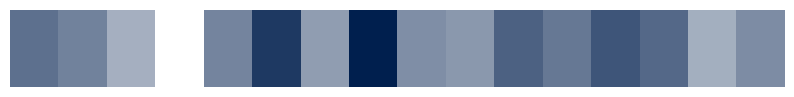

In [31]:
#plotting the SFH as a 1D plot (heatmap)
plt.figure(figsize=(10, 1))
latent = AE.encoder(SFH_test_tensor.unsqueeze(1).to(device)[0])
sim_probs = AE.sim_type_classifier(latent)
plt.imshow(latent[0].cpu().flatten().detach().numpy().reshape(1, -1), cmap=cmap, aspect='auto')
plt.axis('off')

In [29]:
# turn sim_probs into probabilities
sim_probs = torch.nn.functional.softmax(sim_probs, dim=1)
sim_probs = sim_probs.cpu().detach().numpy()
sim_probs

array([[0.96377724, 0.00076915, 0.03532694, 0.00000007, 0.00001365,
        0.0000001 , 0.00011285, 0.        , 0.        , 0.        ]],
      dtype=float32)

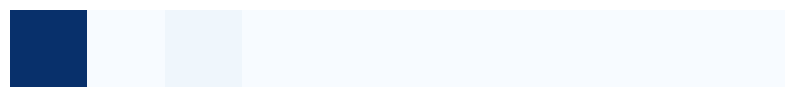

In [141]:
plt.figure(figsize=(10, 1))
plt.imshow(sim_probs.reshape(1, -1), cmap='Blues', aspect='auto')
plt.axis('off')
plt.show()


In [644]:
mass_sfr

tensor([[10.7536,  0.4900]], device='mps:0', grad_fn=<LinearBackward0>)

In [ ]:
# plotting the SFH as a 1D plot (heatmap)
plt.figure(figsize=(10, 1))
latent = AE.encoder(SFH_test_tensor.unsqueeze(1).to(device)[42])
plt.imshow(latent.detach().cpu().reshape(1, -1).numpy(), cmap='hot', aspect='auto')
plt.axis('off')

In [290]:
SFH_data_tensor = torch.tensor(SFH_data, dtype=torch.float32)
labels_data_tensor = torch.tensor(labels_data, dtype=torch.float32)
latent_space = AE.encoder(SFH_data_tensor.unsqueeze(1).to(device)).cpu().detach().numpy()
latent_space.shape

(63110, 16)

In [291]:
import umap
reducer = umap.UMAP(n_components=2, n_neighbors=100)
embedding = reducer.fit_transform(latent_space)
embedding.shape

(63110, 2)

In [298]:
# Turn labels_data_tensor from one hot encoding to array of integers
data_labels = np.argmax(labels_data, axis=1)

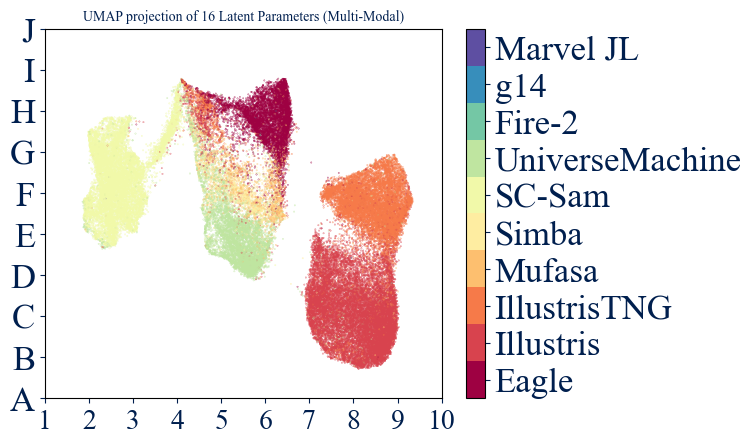

In [655]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'g14', 'Marvel JL']

plt.scatter(embedding[:, 0], embedding[:, 1], c=data_labels, cmap='Spectral', s=0.05)

# Create a colorbar
cbar = plt.colorbar(boundaries=np.arange(11)-0.5, ticks=np.arange(10))

# Set the colorbar labels
cbar.ax.set_yticklabels(labels)

plt.title('UMAP projection of 16 Latent Parameters (Multi-Modal)', fontsize=10)
plt.xlim(-4, 15)
plt.ylim(-4, 8)
grid_x = np.linspace(-4, 15, 10)
grid_y = np.linspace(8, -4, 10)
# plt.xticks(grid_x)
# plt.yticks(grid_y)
# Replacing the axis labels with 10 uniformly arranged integers in the y-axis and 10 uniformly arranged letters in the x-axis
# Put the labels in the middle of the ticks
plt.xticks(np.linspace(-4, 15, 10), [1,2,3,4,5,6,7,8,9,10])
plt.yticks(np.linspace(-4, 8, 10), ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.show()

In [511]:
grid_x = np.linspace(-4, 15, 10)
grid_y = np.linspace(8, -4, 10)

In [538]:
labels_data[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [546]:
mean_SFHs = np.zeros((9, 9, 139))
percentile_SFHs10 = np.zeros((9, 9, 139))
percentile_SFHs90 = np.zeros((9, 9, 139))
most_common_sim = np.zeros((9, 9))
for j in range(9):
    for k in range(9):
        data_in_current_grid = []
        sims_in_current_grid = []
        for i in range(len(embedding)):
            if embedding[i][0] > grid_x[k] and embedding[i][0] < grid_x[k+1] and embedding[i][1] < grid_y[j] and embedding[i][1] > grid_y[j+1]:
                data_in_current_grid.append(SFH_data[i])
                sims_in_current_grid.append(labels_data[i])
        if len(data_in_current_grid) > 10:
            mean_SFHs[k][j] = np.mean(data_in_current_grid, axis=0)
            percentile_SFHs10[k][j] = np.percentile(data_in_current_grid, 10, axis=0)
            percentile_SFHs90[k][j] = np.percentile(data_in_current_grid, 90, axis=0)
            most_common_sim[k][j] = np.argmax(np.bincount(np.argmax(sims_in_current_grid, axis=1).astype(int))).astype(int)
            print(grid_x[k], grid_x[k+1], grid_y[j], grid_y[j+1])
        else:
            mean_SFHs[k][j] = np.zeros(139)


# mean_SFHs = np.zeros((9, 9, 139))
# percentile_SFHs10 = np.zeros((9, 9, 139))
# percentile_SFHs90 = np.zeros((9, 9, 139))
# most_common_sim = np.zeros((9, 9))
# for j in range(9):
#     for k in range(9):
#         data_in_current_grid_indices = []
#         for i in range(len(embedding)):
#             if embedding[i][0] > grid_x[k] and embedding[i][0] < grid_x[k+1] and embedding[i][1] < grid_y[j] and embedding[i][1] > grid_y[j+1]:
#                 data_in_current_grid_indices.append(i)
#         if len(data_in_current_grid_indices) > 10:
#             mean_SFHs[k][j] = np.mean(SFH_data[data_in_current_grid_indices], axis=0)
#             percentile_SFHs10[k][j] = np.percentile(SFH_data[data_in_current_grid_indices], 10, axis=0)
#             percentile_SFHs90[k][j] = np.percentile(SFH_data[data_in_current_grid_indices], 90, axis=0)
#             most_common_sim[k][j] = np.argmax(np.bincount(np.argmax(labels_data[data_in_current_grid_indices], axis=1).astype(int))).astype(int)
#         else:
#             mean_SFHs[k][j] = np.zeros(139)
        

0.22222222222222232 2.333333333333334 6.666666666666667 5.333333333333334
2.333333333333334 4.444444444444445 6.666666666666667 5.333333333333334
4.444444444444445 6.555555555555555 6.666666666666667 5.333333333333334
6.555555555555555 8.666666666666668 6.666666666666667 5.333333333333334
-4.0 -1.8888888888888888 5.333333333333334 4.0
-1.8888888888888888 0.22222222222222232 5.333333333333334 4.0
0.22222222222222232 2.333333333333334 5.333333333333334 4.0
2.333333333333334 4.444444444444445 5.333333333333334 4.0
4.444444444444445 6.555555555555555 5.333333333333334 4.0
6.555555555555555 8.666666666666668 5.333333333333334 4.0
-1.8888888888888888 0.22222222222222232 4.0 2.666666666666667
0.22222222222222232 2.333333333333334 4.0 2.666666666666667
2.333333333333334 4.444444444444445 4.0 2.666666666666667
4.444444444444445 6.555555555555555 4.0 2.666666666666667
6.555555555555555 8.666666666666668 4.0 2.666666666666667
8.666666666666668 10.777777777777779 4.0 2.666666666666667
10.777777777

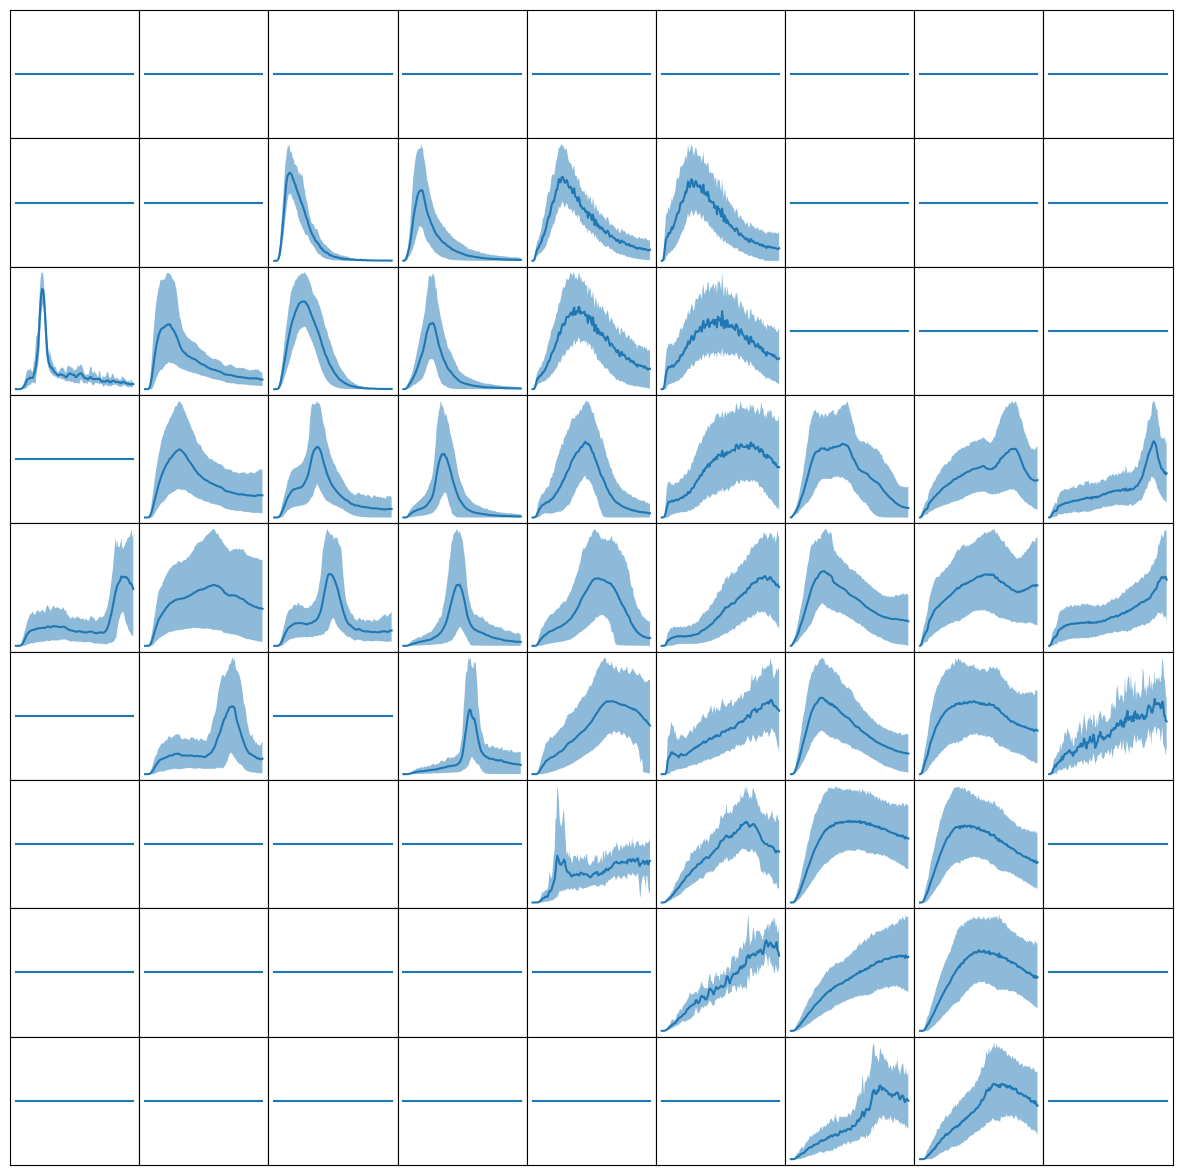

In [549]:
# plotting the mean SFHs in a 10x10 grid without axes and no spaces between them

fig, axs = plt.subplots(9, 9, figsize=(15, 15))

# Adjust the space between subplots
fig.subplots_adjust(hspace=0, wspace=0)

for j in range(9):
    for k in range(9):
        axs[k, j].plot(mean_SFHs[j][k])
        axs[k, j].fill_between(np.arange(139), percentile_SFHs10[j][k], percentile_SFHs90[j][k], alpha=0.5)
        # no labels
        axs[k, j].set_xticks([])
        axs[k, j].set_yticks([])
        # colour the plot according to the most common simulation
plt.show()

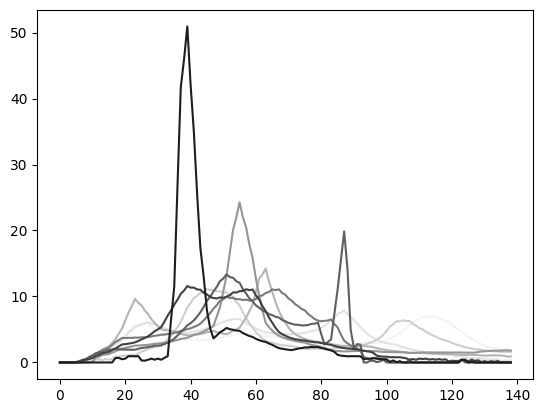

In [320]:
get_ah_from_umap(-2, 2, 3, 4, embedding, latent_space, 10)

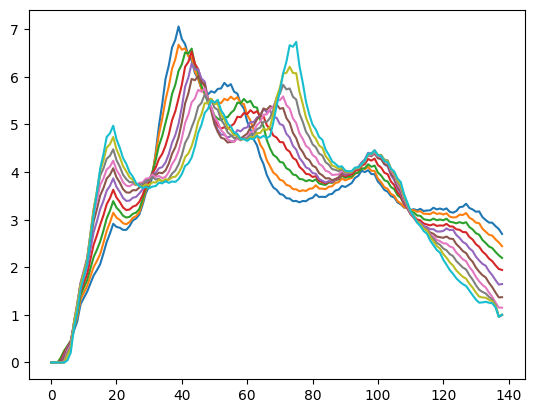

In [396]:
interpolate_parameter_x(3, latent_space, 10)

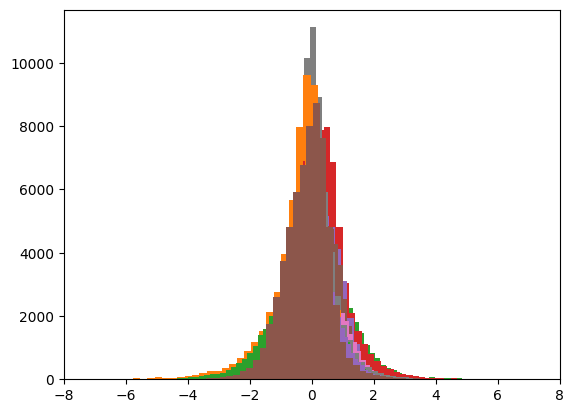

In [347]:
for i in range(16):
    plt.hist(latent_space.T[i], bins=100)
    plt.xlim(-8,8)

In [477]:
embedding.shape

(63110, 2)

In [472]:
from scipy.spatial import distance

def get_ah_from_umap(x1, y1, x2, y2, embedding: np.ndarray, latent_space: np.ndarray, num_observations=10):
    """
    Takes num_observations evenly spaced points along the vector connecting the given UMAP coordinates and plots the corresponding SFHs
    of the closest points in the embedding to the interpolated points.
    (x1, y1) and (x2, y2).
    """
    # Interpolate between the two points
    x_range = np.linspace(x1, x2, num_observations)
    y_range = np.linspace(y1, y2, num_observations)
    
    point_coordinates = [[x_range[i], y_range[i]] for i in range(num_observations)]
    for pair in point_coordinates:
        distances = [distance.euclidean(pair, point) for point in embedding]
        closest_point = np.argmin(distances)
        closest_latent = latent_space[closest_point]
        closest_SFH = AE.decoder(torch.tensor(closest_latent).unsqueeze(0).to(device)).cpu().detach().numpy().squeeze()
        plt.plot(closest_SFH, color=plt.cm.Greys(point_coordinates.index(pair)/num_observations))


def interpolate_parameter_x(x, latent_space, n=10):
    '''
    Plotting the time series data with the decoder by interpolating n times between the 10th percentile and 90th percentile values of latent parameter
    #x, while setting all other parameters to their mean values.
    '''
    latent_space_mean = np.mean(latent_space, axis=0)
    for i in range(n):
        paramts = np.zeros(len(latent_space.T))
        for j in range(len(latent_space.T)):
            if j == x:
                paramts[j] = np.linspace(np.percentile(latent_space.T[j], [10])[0], np.percentile(latent_space.T[j], [90])[0], n)[i]
            else:
                paramts[j] = latent_space_mean[j]
        plt.plot(AE.decoder(torch.tensor(paramts, dtype=torch.float32).unsqueeze(0).to(device))[0][0].cpu().detach().numpy())



In [475]:
print(embedding[:, 0].shape)
print(embedding[:, 1].shape)
print(SFH_data.shape)

(63110,)
(63110,)
(63110, 139)


In [385]:
latent_space[1], data_labels[1]
lat_params_by_sim = [[] for i in range(10)]
mean_params_by_sim = np.zeros((10, 16))
for i in range(len(data_labels)):
    lat_params_by_sim[data_labels[i]].append(latent_space[i])
for i in range(len(lat_params_by_sim)):
    lat_params_by_sim[i] = np.array(lat_params_by_sim[i])
    mean_params_by_sim[i] = np.mean(lat_params_by_sim[i], axis=0)

Text(0.5, 1.0, 'Mean Latent Parameters by Simulation')

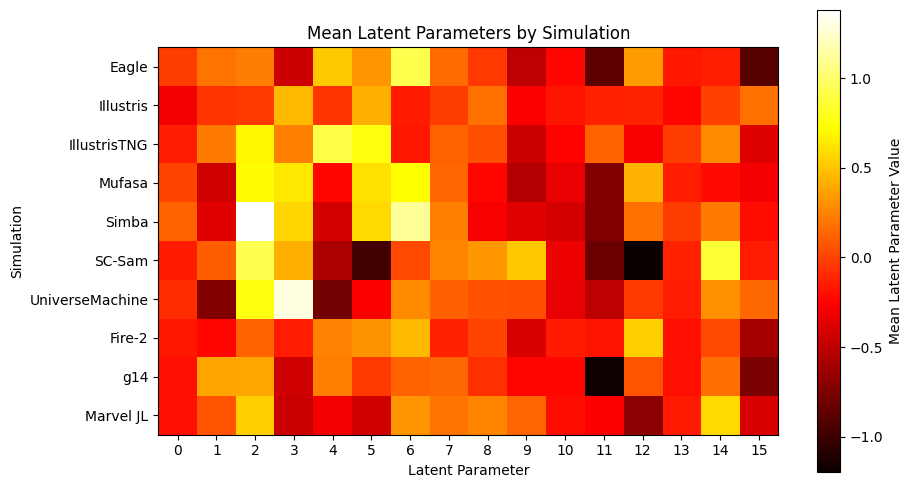

In [390]:
# making a heatmap of the mean latent parameters for each simulation
plt.figure(figsize=(10, 6))
labels = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'g14', 'Marvel JL']
plt.xticks(np.arange(16), np.arange(16))
plt.yticks(np.arange(10), labels)
plt.imshow(mean_params_by_sim, cmap='hot', interpolation='nearest')
plt.colorbar(label='Mean Latent Parameter Value')
plt.xlabel('Latent Parameter')
plt.ylabel('Simulation')
plt.title('Mean Latent Parameters by Simulation')


In [380]:
mean_params_by_sim.shape

(160,)

In [366]:
len(lat_params_by_sim)

7445